In [2]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

Automatically created module for IPython interactive environment


In [3]:
plt.style.use('default')

In [4]:
np.random.seed(0)
n_samples = 3000
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)

/var/folders/_7/3860x3293tn4h2dlrp5_t7_h0000gn/T/ipykernel_73432/2342621459.py:93: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = algorithm.labels_.astype(np.int)
/var/folders/_7/3860x3293tn4h2dlrp5_t7_h0000gn/T/ipykernel_73432/2342621459.py:93: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review yo

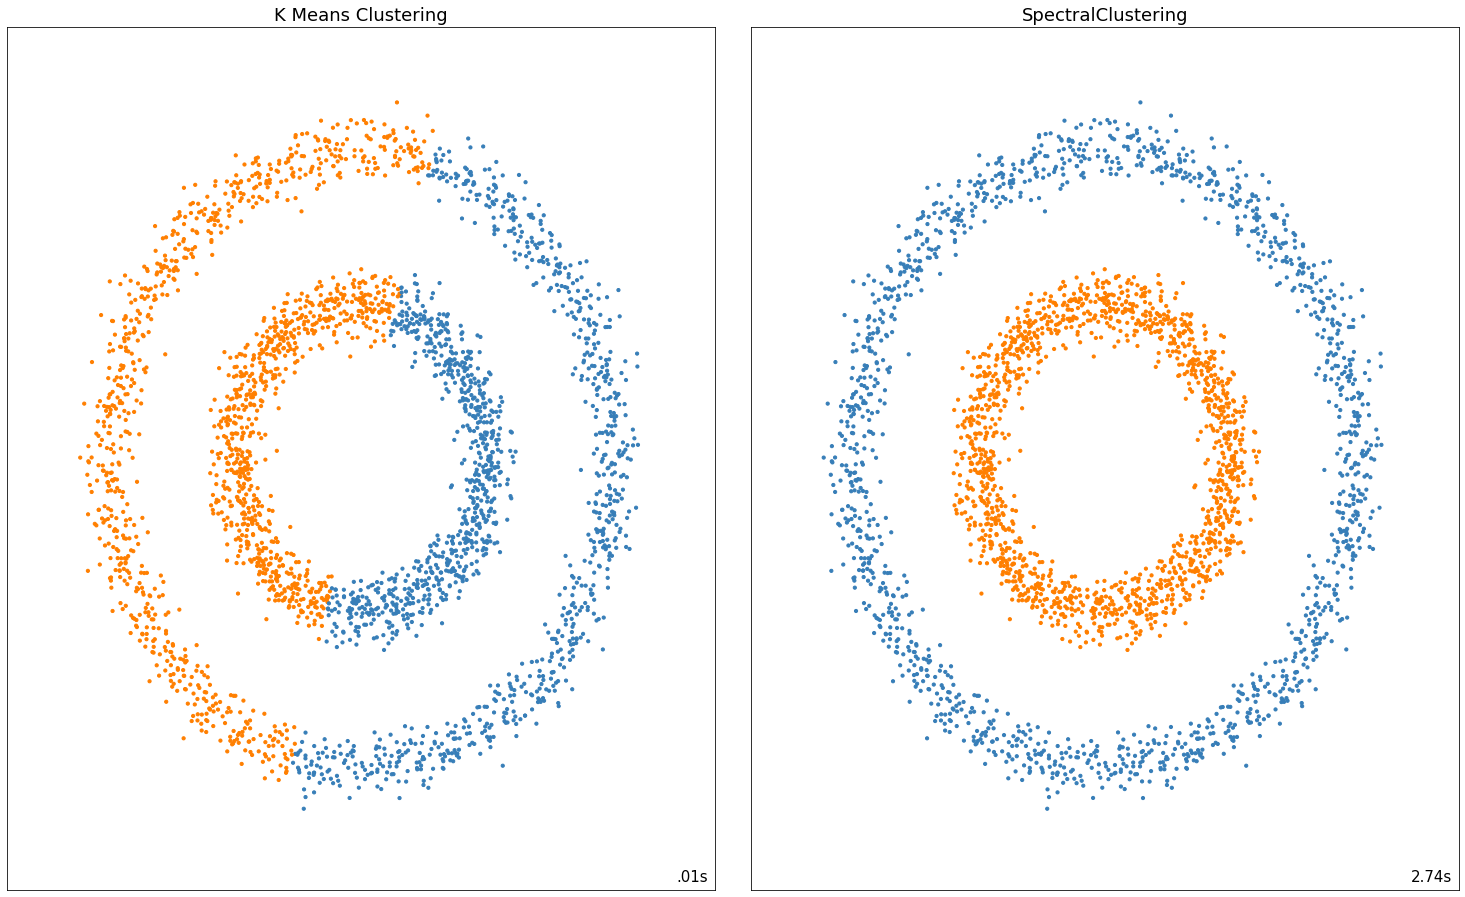

In [9]:
# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", metric="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('K Means Clustering', two_means),
        ('SpectralClustering', spectral)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
        
plt.savefig('comparision.png', transparent='True')
plt.show()

plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)


/var/folders/_7/3860x3293tn4h2dlrp5_t7_h0000gn/T/ipykernel_73432/2835905530.py:80: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = spectral.labels_.astype(np.int)


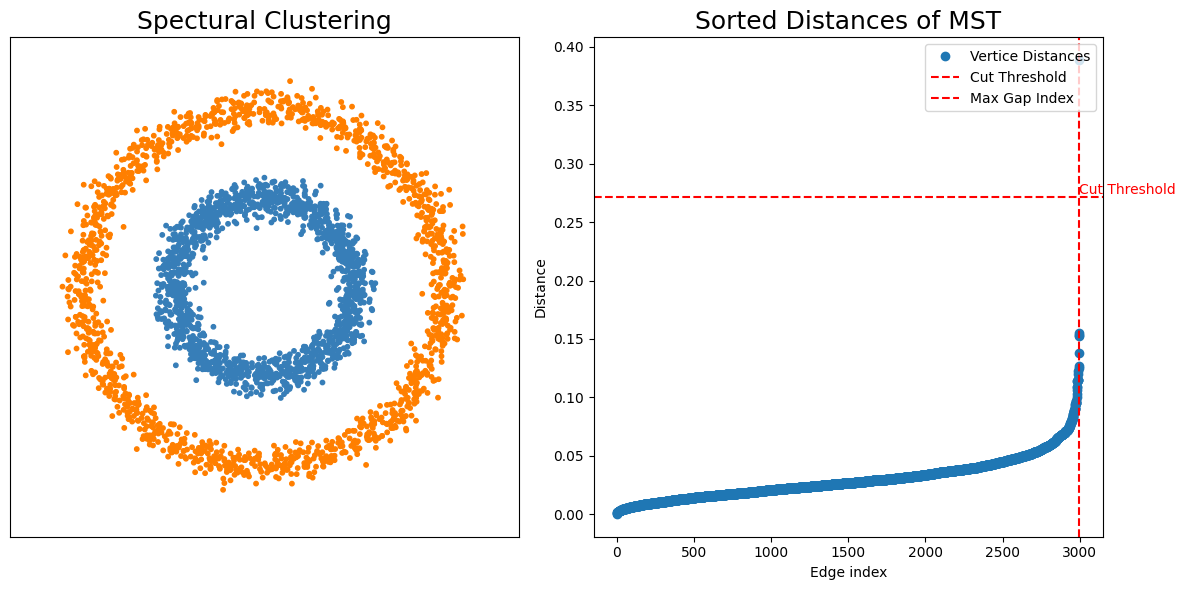

In [13]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree

plt.style.use('default')

np.random.seed(0)
n_samples = 3000
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)

# ============
# Set up cluster parameters
# ============
"""plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)"""
plt.figure(figsize=(12,6))


# plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # Create clustering algorithm
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")

    # Fit clustering algorithm
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding" +
            " may not work as expected.",
            category=UserWarning)
        spectral.fit(X)

    if hasattr(algorithm, 'labels_'):
        y_pred = spectral.labels_.astype(np.int)
    else:
        y_pred = spectral.predict(X)

    # Plot the left subfigure (scatter plot with clusters)
    plt.subplot(1, 2, 1)
    plt.title('Spectural Clustering', size=18)

    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                            '#f781bf', '#a65628', '#984ea3',
                                            '#999999', '#e41a1c', '#dede00']),
                                    int(max(y_pred) + 1))))
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    
    # Compute pairwise distances
    distances = pdist(X, metric='euclidean')
    distance_matrix = squareform(distances)

    # Compute minimum spanning tree
    mst_sparse = minimum_spanning_tree(distance_matrix)

    # Get the edge weights
    mst_coo = mst_sparse.tocoo()
    edge_weights = mst_coo.data

    # Sort the edge weights
    sorted_weights = np.sort(edge_weights)

    # Compute the difference between consecutive weights
    differences = np.diff(sorted_weights)

    # Find the largest differences between consecutive weights
    max_gap_index = np.argmax(differences)
    threshold = (sorted_weights[max_gap_index] + sorted_weights[max_gap_index+1]) / 2

    # plot  the right subfigure (sorted MST edge weights)
    plt.subplot(1, 2, 2)
    plt.plot(range(len(sorted_weights)), sorted_weights, 'o')
    plt.axhline(y=threshold, color='r', linestyle='--')
    plt.axvline(x=max_gap_index, color='r', linestyle='--')
    plt.xlabel('Edge index')
    plt.ylabel('Distance')
    plt.title('Sorted Distances of MST', size=18)
    plt.legend(['Vertice Distances', 'Cut Threshold', 'Max Gap Index'], loc='upper right')
    plt.text(max_gap_index, threshold, 'Cut Threshold', color='r', verticalalignment='bottom')

plt.tight_layout()    
plt.savefig('Clustering_and_distance_boxplot.png', transparent='True')
plt.show()

plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)


/var/folders/_7/3860x3293tn4h2dlrp5_t7_h0000gn/T/ipykernel_73432/3373988906.py:80: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = spectral.labels_.astype(np.int)


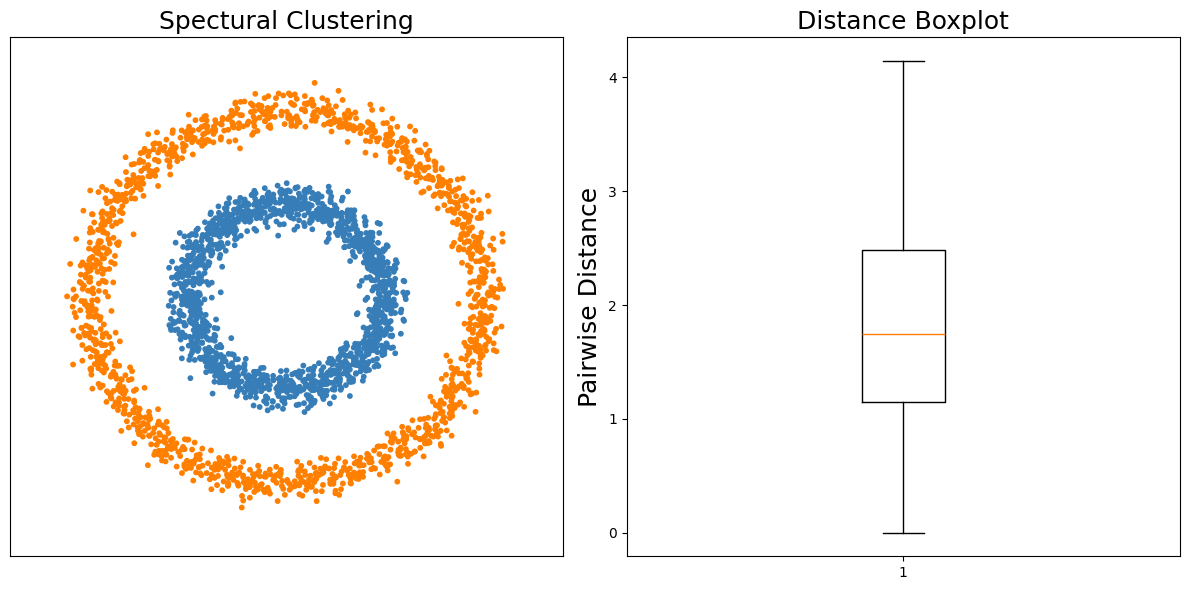

In [14]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree

plt.style.use('default')

np.random.seed(0)
n_samples = 3000
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)

# ============
# Set up cluster parameters
# ============
"""plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)"""
plt.figure(figsize=(12,6))


# plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # Create clustering algorithm
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")

    # Fit clustering algorithm
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding" +
            " may not work as expected.",
            category=UserWarning)
        spectral.fit(X)

    if hasattr(algorithm, 'labels_'):
        y_pred = spectral.labels_.astype(np.int)
    else:
        y_pred = spectral.predict(X)

    # Plot the left subfigure (scatter plot with clusters)
    plt.subplot(1, 2, 1)
    plt.title('Spectural Clustering', size=18)

    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                            '#f781bf', '#a65628', '#984ea3',
                                            '#999999', '#e41a1c', '#dede00']),
                                    int(max(y_pred) + 1))))
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    
    # Compute pairwise distances
    distances = pdist(X, metric='euclidean')

    # plot  the right subfigure (sorted MST edge weights)
    plt.subplot(1, 2, 2)
    plt.boxplot(distances, vert=True)
    plt.ylabel('Pairwise Distance', size=18)
    plt.title('Distance Boxplot', size=18)

plt.tight_layout()    
plt.savefig('Clustering_and_distance_boxplot.png', transparent='True')
plt.show()

plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)


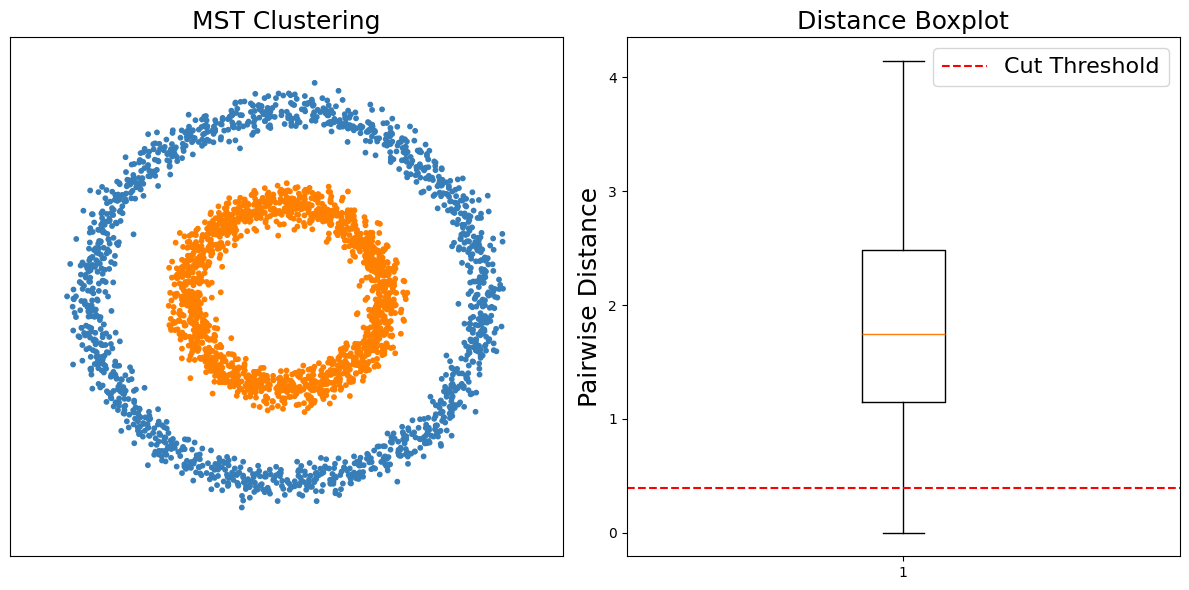

In [17]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree, connected_components

plt.style.use('default')

np.random.seed(0)
n_samples = 3000
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)

# ============
# Set up cluster parameters
# ============
"""plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)"""
plt.figure(figsize=(12,6))


# plot_num = 1

X, y = noisy_circles

# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)

# Compute pairwise distances
distances = pdist(X, metric='euclidean')
distance_matrix = squareform(distances)

# Compute minimum spanning tree
mst_sparse = minimum_spanning_tree(distance_matrix)
mst_sparse = mst_sparse.tocoo()

# Get the edge and weights from the MST
edges = list(zip(mst_sparse.row, mst_sparse.col, mst_sparse.data))

# Sort the edges by weight in descending order
edges_sorted = sorted(edges, key=lambda x: x[2], reverse=True)

# Determine the number of clusters 
num_clusters = 2

# Remove the (num_clusters-1) largest edges to form clusters
edges_to_remove = num_clusters - 1

# Create a copy of the MST adjacency matrix
mst_adj_matrix = mst_sparse.toarray()

# Remove the largest edges
for i in range(edges_to_remove):
    max_edge = edges_sorted[i]

    # Since the MST  is undirected, remove both [row, col] and [col, row]
    mst_adj_matrix[max_edge[0], max_edge[1]] = 0
    mst_adj_matrix[max_edge[1], max_edge[0]] = 0

# Compute connected components (clusters)
n_components, labels = connected_components(mst_adj_matrix, directed=False)

# Plot the left subfigure (scatter plot with MST clusters)
plt.subplot(1, 2, 1)
plt.title('MST Clustering', size=18)

colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                        '#f781bf', '#a65628', '#984ea3',
                                        '#999999', '#e41a1c', '#dede00']),
                                int(max(y_pred) + 1))))
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[labels])

plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.xticks(())
plt.yticks(())

# plot  the right subfigure (box plot of pairwise distances)
plt.subplot(1, 2, 2)
plt.boxplot(distances, vert=True)
plt.ylabel('Pairwise Distance', size=18)
plt.title('Distance Boxplot', size=18)

# Draw a hoorizontal line indicating the threshold used to cut the MST
threshold = edges_sorted[0][2] # Weight of the largest edge
plt.axhline(y=threshold, color='r', linestyle='--', label='Cut Threshold')
plt.legend(loc='upper right', prop={'size': 16})

plt.tight_layout()    
plt.savefig('Clustering_and_distance_boxplot.png', transparent='True')
plt.show()

plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)


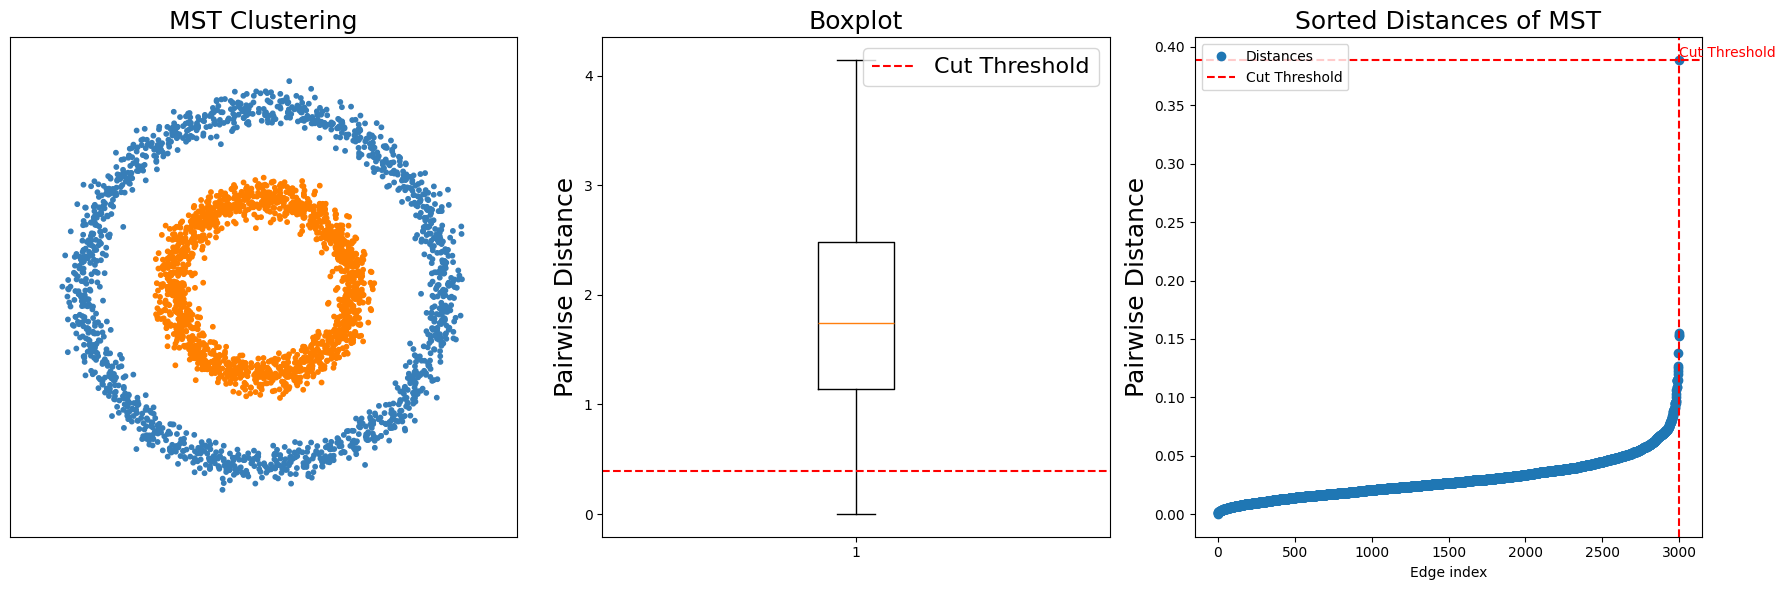

In [34]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree, connected_components

plt.style.use('default')

np.random.seed(0)
n_samples = 3000
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)

# ============
# Set up cluster parameters
# ============
"""plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)"""
plt.figure(figsize=(18,6))


# plot_num = 1

X, y = noisy_circles

# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)

# Compute pairwise distances
distances = pdist(X, metric='euclidean')
distance_matrix = squareform(distances)

# Compute minimum spanning tree
mst_sparse = minimum_spanning_tree(distance_matrix)
mst_sparse = mst_sparse.tocoo()

# Get the edge and weights from the MST
edges = list(zip(mst_sparse.row, mst_sparse.col, mst_sparse.data))

# Sort the edges by weight in descending order
edges_sorted = sorted(edges, key=lambda x: x[2], reverse=True)

# Determine the number of clusters 
num_clusters = 2

# Remove the (num_clusters-1) largest edges to form clusters
edges_to_remove = num_clusters - 1

# Create a copy of the MST adjacency matrix
mst_adj_matrix = mst_sparse.toarray()

# Remove the largest edges
for i in range(edges_to_remove):
    max_edge = edges_sorted[i]

    # Since the MST  is undirected, remove both [row, col] and [col, row]
    mst_adj_matrix[max_edge[0], max_edge[1]] = 0
    mst_adj_matrix[max_edge[1], max_edge[0]] = 0

# Compute connected components (clusters)
n_components, labels = connected_components(mst_adj_matrix, directed=False)

# Plot the left subfigure (scatter plot with MST clusters)
plt.subplot(1, 3, 1)
plt.title('MST Clustering', size=18)

colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                        '#f781bf', '#a65628', '#984ea3',
                                        '#999999', '#e41a1c', '#dede00']),
                                int(max(y_pred) + 1))))
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[labels])

plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.xticks(())
plt.yticks(())

# Get the edge weights
edge_weights = mst_sparse.data
# Sort the edge weights
sorted_weights = np.sort(edge_weights)
# Compute the difference between consecutive weights
differences = np.diff(sorted_weights)
# Find the largest differences between consecutive weights
max_gap_index = np.argmax(differences)

# plot  the right subfigure (box plot of pairwise distances)
plt.subplot(1, 3, 2)
plt.boxplot(distances, vert=True)
plt.ylabel('Pairwise Distance', size=18)
plt.title('Boxplot', size=18)
# Draw a hoorizontal line indicating the threshold used to cut the MST
threshold = edges_sorted[0][2] # Weight of the largest edge
plt.axhline(y=threshold, color='r', linestyle='--', label='Cut Threshold')
plt.legend(loc='upper right', prop={'size': 16})

# plot  the right subfigure (sorted MST edge weights)
plt.subplot(1, 3, 3)
plt.plot(range(len(sorted_weights)), sorted_weights, 'o')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axvline(x=max_gap_index, color='r', linestyle='--')
plt.xlabel('Edge index')
plt.ylabel('Pairwise Distance', size=18)
plt.title('Sorted Distances of MST', size=18)
plt.legend(['Distances', 'Cut Threshold'], loc='upper left')
plt.text(max_gap_index, threshold, 'Cut Threshold', color='r', verticalalignment='bottom')

plt.tight_layout()    
plt.savefig('Clustering_and_distance_boxplot.png', transparent='True')
plt.show()

plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)


/var/folders/_7/3860x3293tn4h2dlrp5_t7_h0000gn/T/ipykernel_73432/2832043686.py:98: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([distances, sorted_weights], labels=['All Distances', 'Distances in MST'], vert=True)


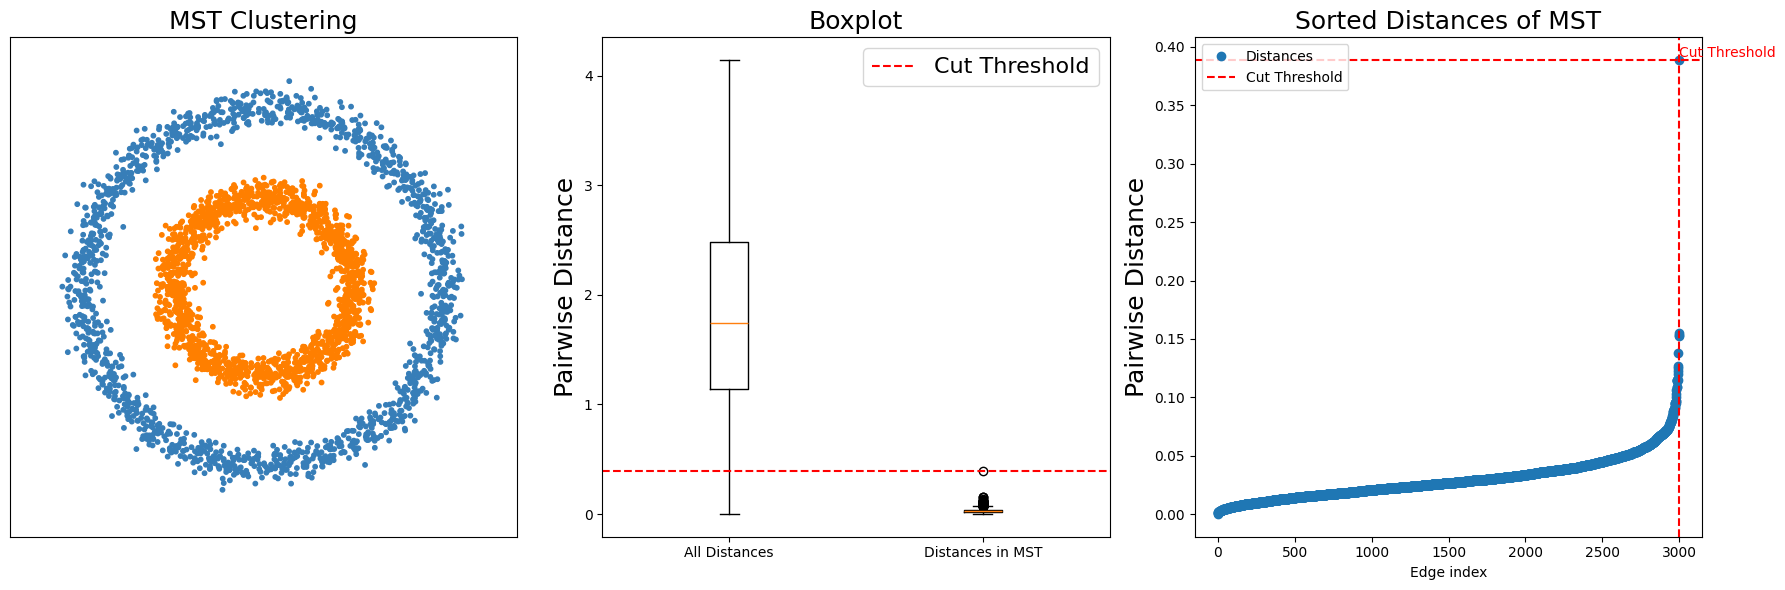

In [37]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree, connected_components

plt.style.use('default')

np.random.seed(0)
n_samples = 3000
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(18,6))


# plot_num = 1

X, y = noisy_circles

# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)

# Compute pairwise distances
distances = pdist(X, metric='euclidean')
distance_matrix = squareform(distances)

# Compute minimum spanning tree
mst_sparse = minimum_spanning_tree(distance_matrix)
mst_sparse = mst_sparse.tocoo()

# Get the edge and weights from the MST
edges = list(zip(mst_sparse.row, mst_sparse.col, mst_sparse.data))

# Sort the edges by weight in descending order
edges_sorted = sorted(edges, key=lambda x: x[2], reverse=True)

# Determine the number of clusters 
num_clusters = 2

# Remove the (num_clusters-1) largest edges to form clusters
edges_to_remove = num_clusters - 1

# Create a copy of the MST adjacency matrix
mst_adj_matrix = mst_sparse.toarray()

# Remove the largest edges
for i in range(edges_to_remove):
    max_edge = edges_sorted[i]

    # Since the MST  is undirected, remove both [row, col] and [col, row]
    mst_adj_matrix[max_edge[0], max_edge[1]] = 0
    mst_adj_matrix[max_edge[1], max_edge[0]] = 0

# Compute connected components (clusters)
n_components, labels = connected_components(mst_adj_matrix, directed=False)

# Plot the left subfigure (scatter plot with MST clusters)
plt.subplot(1, 3, 1)
plt.title('MST Clustering', size=18)

colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                        '#f781bf', '#a65628', '#984ea3',
                                        '#999999', '#e41a1c', '#dede00']),
                                int(max(y_pred) + 1))))
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[labels])

plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.xticks(())
plt.yticks(())

# Get the edge weights
edge_weights = mst_sparse.data
# Sort the edge weights
sorted_weights = np.sort(edge_weights)
# Compute the difference between consecutive weights
differences = np.diff(sorted_weights)
# Find the largest differences between consecutive weights
max_gap_index = np.argmax(differences)

# plot  the right subfigure (box plot of pairwise distances)
plt.subplot(1, 3, 2)
plt.boxplot([distances, sorted_weights], labels=['All Distances', 'Distances in MST'], vert=True)
plt.ylabel('Pairwise Distance', size=18)
plt.title('Boxplot', size=18)
# Draw a hoorizontal line indicating the threshold used to cut the MST
threshold = edges_sorted[0][2] # Weight of the largest edge
plt.axhline(y=threshold, color='r', linestyle='--', label='Cut Threshold')
plt.legend(loc='upper right', prop={'size': 16})

# plot  the right subfigure (sorted MST edge weights)
plt.subplot(1, 3, 3)
plt.plot(range(len(sorted_weights)), sorted_weights, 'o')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axvline(x=max_gap_index, color='r', linestyle='--')
plt.xlabel('Edge index')
plt.ylabel('Pairwise Distance', size=18)
plt.title('Sorted Distances of MST', size=18)
plt.legend(['Distances', 'Cut Threshold'], loc='upper left')
plt.text(max_gap_index, threshold, 'Cut Threshold', color='r', verticalalignment='bottom')

plt.tight_layout()    
plt.savefig('Clustering_and_distance_boxplot.png', transparent='True')
plt.show()

plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)


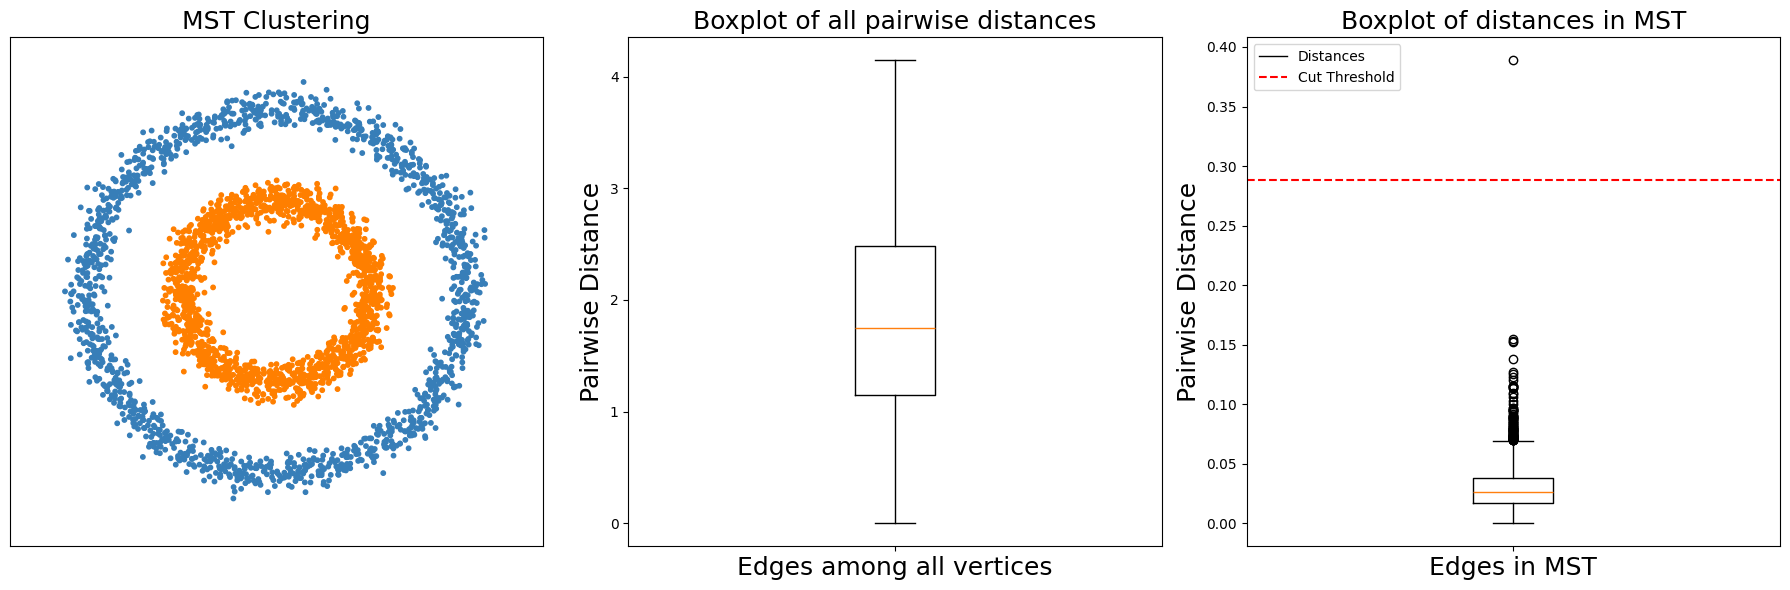

In [55]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree, connected_components

plt.style.use('default')

np.random.seed(0)
n_samples = 3000
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(18,6))


# plot_num = 1

X, y = noisy_circles

# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)

# Compute pairwise distances
distances = pdist(X, metric='euclidean')
distance_matrix = squareform(distances)

# Compute minimum spanning tree
mst_sparse = minimum_spanning_tree(distance_matrix)
mst_sparse = mst_sparse.tocoo()

# Get the edge and weights from the MST
edges = list(zip(mst_sparse.row, mst_sparse.col, mst_sparse.data))

# Sort the edges by weight in descending order
edges_sorted = sorted(edges, key=lambda x: x[2], reverse=True)

# Determine the number of clusters 
num_clusters = 2

# Remove the (num_clusters-1) largest edges to form clusters
edges_to_remove = num_clusters - 1

# Create a copy of the MST adjacency matrix
mst_adj_matrix = mst_sparse.toarray()

# Remove the largest edges
for i in range(edges_to_remove):
    max_edge = edges_sorted[i]

    # Since the MST  is undirected, remove both [row, col] and [col, row]
    mst_adj_matrix[max_edge[0], max_edge[1]] = 0
    mst_adj_matrix[max_edge[1], max_edge[0]] = 0

# Compute connected components (clusters)
n_components, labels = connected_components(mst_adj_matrix, directed=False)

# Plot the left subfigure (scatter plot with MST clusters)
plt.subplot(1, 3, 1)
plt.title('MST Clustering', size=18)

colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                        '#f781bf', '#a65628', '#984ea3',
                                        '#999999', '#e41a1c', '#dede00']),
                                int(max(y_pred) + 1))))
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[labels])

plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.xticks(())
plt.yticks(())

# Get the edge weights
edge_weights = mst_sparse.data
# Sort the edge weights
sorted_weights = np.sort(edge_weights)
# Compute the difference between consecutive weights
differences = np.diff(sorted_weights)
# Find the largest differences between consecutive weights
max_gap_index = np.argmax(differences)

# plot  the right subfigure (box plot of pairwise distances)
plt.subplot(1, 3, 2)
plt.boxplot(distances, vert=True)
plt.ylabel('Pairwise Distance', size=18)
plt.xticks([1],['Edges among all vertices'], size=18)
plt.title('Boxplot of all pairwise distances', size=18)

# plot  the right subfigure (sorted MST edge weights)
plt.subplot(1, 3, 3)
plt.boxplot(sorted_weights, vert=True)
plt.ylabel('Pairwise Distance', size=18)
plt.xticks([1],['Edges in MST'], size=18)
plt.axhline(y=threshold-0.1, color='r', linestyle='--')
plt.title('Boxplot of distances in MST', size=18)
plt.legend(['Distances', 'Cut Threshold'], loc='upper left')

plt.tight_layout()    
plt.savefig('Clustering_and_distance_boxplot.png', transparent='True')
plt.show()

plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)


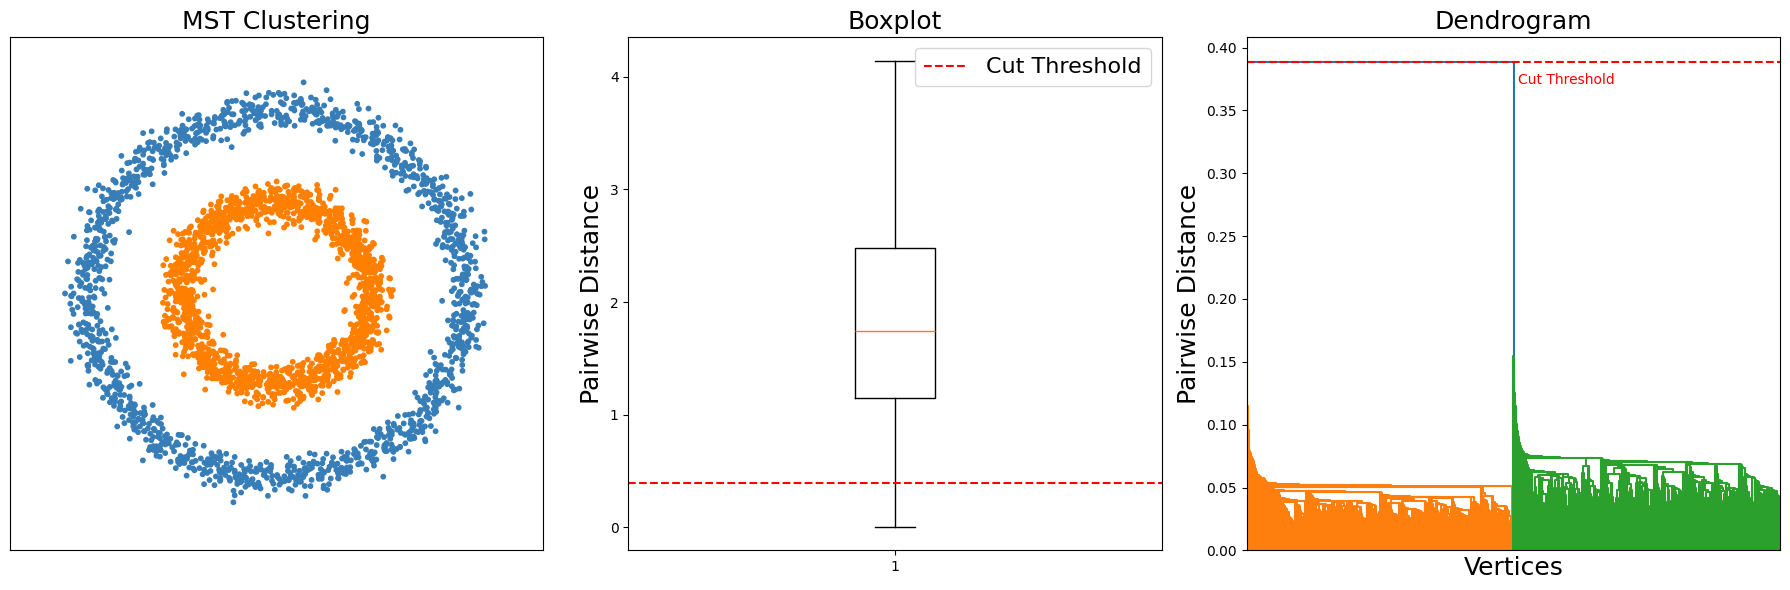

In [26]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree, connected_components
from scipy.cluster.hierarchy import linkage, dendrogram

plt.style.use('default')

np.random.seed(0)
n_samples = 3000
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)

# ============
# Set up cluster parameters
# ============

plt.figure(figsize=(18,6))


# plot_num = 1

X, y = noisy_circles

# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)

# Compute pairwise distances
distances = pdist(X, metric='euclidean')
distance_matrix = squareform(distances)

# Compute minimum spanning tree
mst_sparse = minimum_spanning_tree(distance_matrix)
mst_sparse = mst_sparse.tocoo()

# Get the edge and weights from the MST
edges = list(zip(mst_sparse.row, mst_sparse.col, mst_sparse.data))

# Sort the edges by weight in descending order
edges_sorted = sorted(edges, key=lambda x: x[2], reverse=True)

# Determine the number of clusters 
num_clusters = 2

# Remove the (num_clusters-1) largest edges to form clusters
edges_to_remove = num_clusters - 1

# Create a copy of the MST adjacency matrix
mst_adj_matrix = mst_sparse.toarray()

# Remove the largest edges
for i in range(edges_to_remove):
    max_edge = edges_sorted[i]

    # Since the MST  is undirected, remove both [row, col] and [col, row]
    mst_adj_matrix[max_edge[0], max_edge[1]] = 0
    mst_adj_matrix[max_edge[1], max_edge[0]] = 0

# Compute connected components (clusters)
n_components, labels = connected_components(mst_adj_matrix, directed=False)

# Plot the left subfigure (scatter plot with MST clusters)
plt.subplot(1, 3, 1)
plt.title('MST Clustering', size=18)

colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                        '#f781bf', '#a65628', '#984ea3',
                                        '#999999', '#e41a1c', '#dede00']),
                                int(max(y_pred) + 1))))
# Add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[labels])

plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.xticks(())
plt.yticks(())

# plot  the right subfigure (box plot of pairwise distances)
plt.subplot(1, 3, 2)
plt.boxplot(distances, vert=True)
plt.ylabel('Pairwise Distance', size=18)
plt.title('Boxplot', size=18)
# Draw a hoorizontal line indicating the threshold used to cut the MST
threshold = edges_sorted[0][2] # Weight of the largest edge
plt.axhline(y=threshold, color='r', linestyle='--', label='Cut Threshold')
plt.legend(loc='upper right', prop={'size': 16})

# Compute linkage matrix using single linkage method
Z = linkage(distances, method='single')

# plot  the right subfigure (dendrogram)
plt.subplot(1, 3, 3)
dendrogram(Z, no_labels=True, color_threshold=threshold)
plt.axhline(y=threshold, color='r', linestyle='--')
plt.xlabel('Vertices', size=18)
plt.ylabel('Pairwise Distance', size=18)
plt.title('Dendrogram', size=18)
plt.text(0.6, threshold - 0.02, 'Cut Threshold', color='r', horizontalalignment='center', 
         verticalalignment='bottom', transform=plt.gca().get_yaxis_transform())

plt.tight_layout()    
plt.savefig('Clustering_distance_boxplot_dendrogram.png', transparent='True')
plt.show()

Confusion matrix between MST and Dendrogram labels:
[[   0    0 1500]
 [   0 1500    0]
 [   0    0    0]]
Label mapping from dendrogram labels to MST labels:
{3: 0, 2: 1, 1: 2}


TypeError: 'int' object is not subscriptable

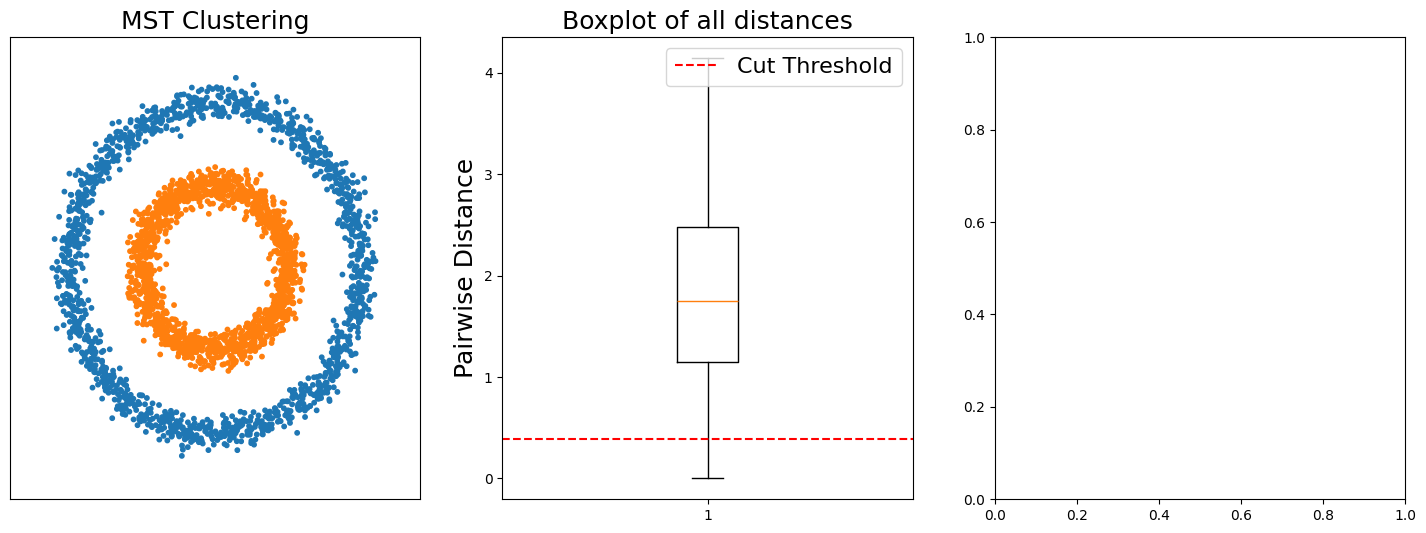

In [36]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree, connected_components
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

plt.style.use('default')

np.random.seed(0)
n_samples = 3000
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)

# ============
# Set up cluster parameters
# ============

plt.figure(figsize=(18,6))


# plot_num = 1

X, y = noisy_circles

# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)

# Compute pairwise distances
distances = pdist(X, metric='euclidean')
distance_matrix = squareform(distances)

# Compute minimum spanning tree
mst_sparse = minimum_spanning_tree(distance_matrix)
mst_sparse = mst_sparse.tocoo()

# Get the edge and weights from the MST
edges = list(zip(mst_sparse.row, mst_sparse.col, mst_sparse.data))

# Sort the edges by weight in descending order
edges_sorted = sorted(edges, key=lambda x: x[2], reverse=True)

# Determine the number of clusters 
num_clusters = 2

# Remove the (num_clusters-1) largest edges to form clusters
edges_to_remove = num_clusters - 1

# Create a copy of the MST adjacency matrix
mst_adj_matrix = mst_sparse.toarray()

# Remove the largest edges
for i in range(edges_to_remove):
    max_edge = edges_sorted[i]

    # Since the MST  is undirected, remove both [row, col] and [col, row]
    mst_adj_matrix[max_edge[0], max_edge[1]] = 0
    mst_adj_matrix[max_edge[1], max_edge[0]] = 0

# Compute connected components (clusters)
n_components, labels = connected_components(mst_adj_matrix, directed=False)

# Map cluster labels to colors
cluster_colors = ['C0', 'C1']  # 'C0' is blue, 'C1' is orange
# Create a color array for the scatter plot
colors = np.array(cluster_colors)

# Plot the left subfigure (scatter plot with MST clusters)
plt.subplot(1, 3, 1)
plt.title('MST Clustering', size=18)

plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[labels])

plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.xticks(())
plt.yticks(())

# plot  the right subfigure (box plot of pairwise distances)
plt.subplot(1, 3, 2)
plt.boxplot(distances, vert=True)
plt.ylabel('Pairwise Distance', size=18)
plt.title('Boxplot of all distances', size=18)
# Draw a hoorizontal line indicating the threshold used to cut the MST
threshold = edges_sorted[0][2] # Weight of the largest edge
plt.axhline(y=threshold, color='r', linestyle='--', label='Cut Threshold')
plt.legend(loc='upper right', prop={'size': 16})

# Compute linkage matrix using single linkage method
Z = linkage(X, method='single', metric='euclidean')

# Compute cluster labels from dendrogram using number of clusters
dendro_labels = fcluster(Z, t=num_clusters, criterion='maxclust')

from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_mat = confusion_matrix(labels, dendro_labels)
print("Confusion matrix between MST and Dendrogram labels:")
print(conf_mat)

# Use the Hungarian algorithm to find the best assignment
row_ind, col_ind = linear_sum_assignment(-conf_mat)

# Create a label mapping based on the assignment
label_mapping = {}
for mst_label, dendro_label in zip(row_ind, col_ind):
    label_mapping[dendro_label + 1] = mst_label # Adjust for label indexing

print("Label mapping from dendrogram labels to MST labels:")
print(label_mapping)

# Define a function to map link colors
def link_color_func(link):
    cluster_id = dendro_labels[link[0]] # Get the cluster ID for the first leaf
    mst_label = label_mapping[cluster_id] # Map the cluster ID to an MST label
    return cluster_colors[mst_label] # Return the corresponding color

# plot  the right subfigure (dendrogram)
plt.subplot(1, 3, 3)
dendro = dendrogram(Z, no_labels=True, color_threshold=0, 
                    link_color_func=link_color_func, above_threshold_color='k')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.xlabel('Vertices', size=18)
plt.ylabel('Pairwise Distance', size=18)
plt.title('Dendrogram of MST', size=18)
plt.text(0.6, threshold - 0.02, 'Cut Threshold', color='r', horizontalalignment='center', 
         verticalalignment='bottom', transform=plt.gca().get_yaxis_transform())

plt.tight_layout()    
plt.savefig('Clustering_distance_boxplot_dendrogram.png', transparent='True')
plt.show()